In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix
import seaborn as sns  



from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.semi_supervised import LabelSpreading

# Hello:)

plt.rcParams['figure.figsize'] = (8, 8)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Custom Dataset

In [27]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
from PIL import Image
from torchvision import transforms
import csv


class Number16(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        with open(csv_file, "r") as file:
          classes = set()
          csv_reader = csv.reader(file)

          for i, row in enumerate(csv_reader):
            if i != 0:
              column = row[1]
              classes.add(column)


        self.classes = classes


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])

        for i in img_path:
          if i == " ":
            img_path = img_path.replace(' ', '')

        image = Image.open(img_path).convert('L')  # Convert to grayscale upon loading
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label


excel = 'DATASET/Excel.csv'
imgs = 'DATASET/img'




dataset = Number16(
    csv_file = excel,
    root_dir = imgs,
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to 128x128
        transforms.ToTensor()  # Convert the image to a tensor
    ])
)



train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset,
                                          batch_size=256,
                                          shuffle=True),

    'test'  : torch.utils.data.DataLoader(test_dataset,
                                          batch_size=64,
                                          shuffle=True)
}



print("Number of images in dataset: ",len(dataset))

print("this dataset contains",len(dataset.classes) ,"clases: ", dataset.classes)

print("Number of images in training dataset: ",len(train_dataset))

print("Number of images in testing dataset: ",len(test_dataset))

Number of images in dataset:  3840
this dataset contains 16 clases:  {'6', '11', '5', '14', '8', '13', '3', '4', '0', '10', '12', '2', '15', '7', '1', '9'}
Number of images in training dataset:  3072
Number of images in testing dataset:  768


In [ ]:
dataset.annotations

In [ ]:
# Particular image plotting

index = 3838
image, label = dataset[index]

if not isinstance(image, np.ndarray):
    image = np.array(image)
    image = np.squeeze(image)

# Plot the image
plt.imshow(image, cmap='gray')  # Adjust the colormap if necessary
plt.title(f'{label} index: {index}' )
plt.show()

In [ ]:
# Random multiple images plotting
import random
figure = plt.figure(figsize=(10, 8))
cols, rows = 6, 3
for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(train_dataset))
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'{label}, inx:({sample_idx})')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# AI 

In [28]:
#                   PRINCIPLE
# 1. too many neurons results into overfitting, low generalization because the AI is trained aggresively on the training dataset



#                   USEFULL PROGRAMMING
# 1. nn.Linear(layer1, layer2) is a fully connected 2 layers



import torch.nn as nn

class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Sequential( nn.Conv2d(                   # 128*128
        in_channels=1,
        out_channels=16,
        kernel_size=(3,3)                     # 126*126
        ), nn.ReLU(), nn.MaxPool2d(
                    kernel_size=(2,2),
                    stride=2
                    )  )                  # 63*63


    self.conv2 = nn.Sequential ( nn.Conv2d(
        in_channels=16,
        out_channels=32,
        kernel_size=(3,3)                # 61*61
        ), nn.ReLU(), nn.MaxPool2d(
                    kernel_size=(2,2),
                    stride=2
                    )  )                      # 30*30
    

    self.conv3 = nn.Sequential(nn.Conv2d( 
      in_channels=32,
      out_channels=32,
      kernel_size=(3,3)                      # 28*28  
      ), nn.ReLU(), nn.MaxPool2d(
                    kernel_size=(2,2),
                    stride=2                 # 14*14*32
                    )   )




    self.fc1 = nn.Sequential(
        nn.Linear(14*14*32, 350),
        nn.ReLU()
        )
    
    self.dropout = nn.Dropout(0.25)

    self.out = nn.Sequential(
        nn.Linear(350, 16),
        nn.Softmax(dim=1)
        )
    


    



  def forward(self, data):
    data = self.conv1(data)
    data = self.conv2(data)
    data = self.conv3(data)


    data = data.view(data.size(0), -1)
    data = self.fc1(data)
    data = self.dropout(data)
    data = self.out(data)
    return data






In [29]:
### TESTING FUNCTION


from torch.autograd import Variable
import time


def batch_test(cnn, loaders, device, writer, epoch): 

    cnn.eval()

    # Train the model
    total_step = len(loaders['test'])
    losses = []
    accuracies = []

    b_y_list = []
    predictions_list = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(loaders['test']):         

            b_x = images.to(device=device)        #data
            b_y = labels.to(device=device)    #target/label

            output = cnn.forward(b_x)

            loss = loss_func(output, b_y)
         

            #  Calculate 'running' training accuracy
            features = b_x.reshape(b_x.shape[0], -1)
            img_grid = torchvision.utils.make_grid(b_x)
            _, predictions = output.max(1)
            num_correct = (predictions == b_y).sum()
            running_train_acc = float(num_correct) / float(b_x.shape[0])
            accuracies.append(running_train_acc)
            losses.append(loss.item())

            b_y_list.extend(b_y.cpu().numpy())
            predictions_list.extend(predictions.cpu().numpy())

    # logging data
    writer.add_scalar('Loss/test', losses[-1], epoch)
    writer.add_scalar('Accuracy/test', accuracies[-1], epoch)

    return losses, accuracies, b_y_list, predictions_list

In [30]:
### TRAINING FUNCTION


from torch.autograd import Variable
import time



def train(num_epochs, cnn, loaders, layout):  

    cnn.train()

    writer = SummaryWriter()
    # writer.add_custom_scalars(layout)


    total_step = len(loaders['train'])

    losses = []
    accuracies = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):         

            b_x = images.to(device=device)        #data
            b_y = labels.to(device=device)    #target/label

            output = cnn.forward(b_x)


            # backpropagation

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
         

            #  Calculate 'running' training accuracy
            features = b_x.reshape(b_x.shape[0], -1)
            img_grid = torchvision.utils.make_grid(b_x)
            _, predictions = output.max(1)
            num_correct = (predictions == b_y).sum()
            running_train_acc = float(num_correct) / float(b_x.shape[0])
            accuracies.append(running_train_acc)
            losses.append(loss.item())
            
        

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))



        # validation on data yet unseen
        _, _, b_y, predictions = batch_test(cnn, loaders, device, writer, epoch)


        # logging data
        writer.add_scalar('Loss/train', losses[-1], epoch)
        writer.add_scalar('Accuracy/train', accuracies[-1], epoch)


    # confusion metrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(b_y, predictions, cmap="Blues")

    

    return losses, accuracies, conf_matrix

In [ ]:
from torch import optim

# layout = {
#     "Epoch Progress": {
#         "losses": ["Multiline", ["Loss/train", "Loss/test"]],
#         "accuracies": ["Multiline", ["Accuracy/train", "Accuracy/test"]],
#     },
# }
layout = False    # just uncomment the layout above and one line of code in train function


iterate = 3
num_epochs = 400
conf_matrices = []

for i in range(iterate):
    cnn = CNN()
    cnn.to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.001, weight_decay =  0.001)

    _, _, conf_matrix = train(num_epochs, cnn, loaders, layout)

    conf_matrices.append(conf_matrix)     

7
[9, 2, 7, 0, 12, 4, 15]


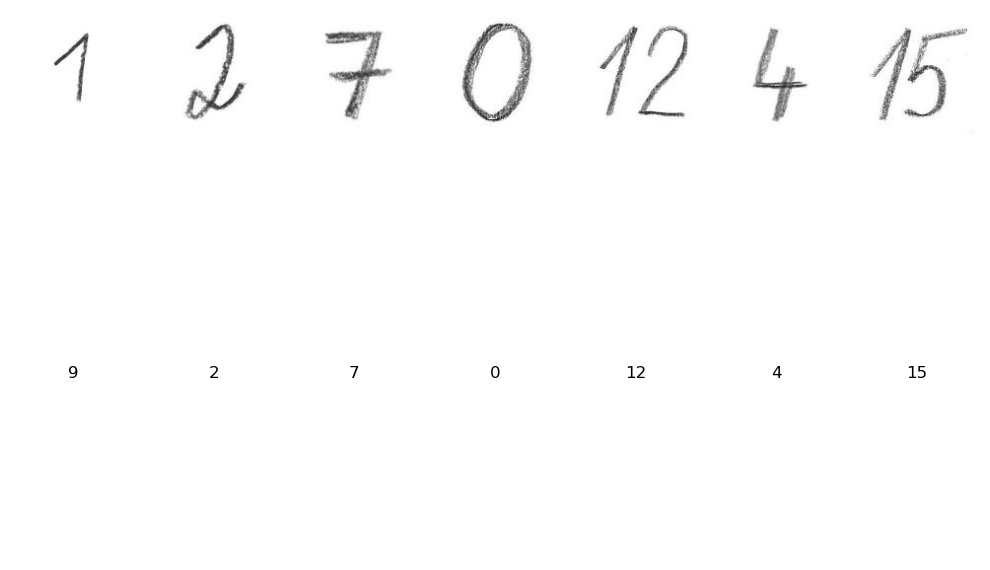

In [42]:
############ TRYING OUT THE MODEL ON REAL LIFE EXAMPLES ##############



####### LOADING DATA ########

import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing your images
image_folder = "mama-cisla"

# List to store image file paths
image_files = []

# Iterate over files in the image folder
for filename in os.listdir(image_folder):
    # Check if the file is an image (you can add more extensions if needed)
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        # Construct the full file path
        filepath = os.path.join(image_folder, filename)
        # Append the file path to the list
        image_files.append(filepath)

images = image_files


from PIL import Image
import torch
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.Grayscale(),         # Convert images to grayscale
    transforms.Resize((128, 128)),  # Resize the images to a fixed size (e.g., 128x128)
    transforms.ToTensor(),          # Convert images to tensors
])

images = torch.stack([transform(Image.open(img_path)) for img_path in images])
images = images.to(device)








####### EVALUATION ########

cnn.eval()
all_predictions = []

with torch.no_grad():

    for i in range(len(images)):
        images[i] = images[i].to(device)


    test_output = cnn(images)        # 7 x 16


    for i in range(7):
        pred_y = torch.max(test_output[i], 0)[1].data 
        pred_y = pred_y.data
        all_predictions.append(pred_y)

all_predictions = [t.item() for t in all_predictions]







####### VISUALIZATION ########

integers = all_predictions
num_images = len(image_files)
rows = 2  
cols = num_images

fig = plt.figure(figsize=(10, 7))

for i, (image_path, integer) in enumerate(zip(image_files, integers)):

    ax = fig.add_subplot(rows, cols, i + 1)
    image = Image.open(image_path)
    

    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    ax.imshow(image)
    ax.axis('off')
    

    ax = fig.add_subplot(rows, cols, num_images + i + 1)
    ax.text(0.5, 0.5, str(integer), fontsize=12, ha='center')
    ax.axis('off')

plt.tight_layout()
plt.show()

